## Declaração de bibliotecas e demais configurações

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import csv
import matplotlib.gridspec as gridspec

import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm


from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score

#from matplotlib import rcParams
#rcParams['text.usetex'] = True
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

## Funções relacionadas ao método ou auxiliares

In [2]:
#Função de leitura dos dados------------------------------------
def read_class_data(path):
    with open(path, newline='') as f:
        reader = csv.reader(f,delimiter=',')
        for row in reader:
            try:
                data = np.vstack( (data , np.asarray(row).astype(np.float) ) )
            except:
                data = np.asarray(row).astype(np.float)
    f.close()
    y = data[:,0]
    x = data[:,1:]
    return y,x

In [3]:
#--------------------------------------
def compute_kappa_varkappa(matConf):
    
    total = float(sum(sum(matConf)))
    c = len(matConf[0])
    diag = float(sum(matConf.diagonal()))
    acGlobal = float(diag/total)
    
    marg = 0.0
    for i in range(0,c):
        marg += sum(matConf[i,:])*sum(matConf[:,i])
    
    #Coeficiente kappa
    kappa = (total*diag - marg)/(total*total - marg)
    
    phi1 = acGlobal; phi2 = marg/((total)**2)
    phi3 = 0.0; phi4 = 0.0
    for i in range(0,c):
        phi3 += matConf[i,i]*(sum(matConf[i,:])+sum(matConf[:,i]))
    for i in range(0,c):
        for j in range(0,c):
            phi4 += matConf[i,j]*((sum(matConf[j,:])+sum(matConf[:,i]))**2)
    
    phi3 = phi3/((total)**2)
    phi4 = phi4/((total)**3)
    
    #Variância do coeficiente kappa
    vkappa = (1/total)*( ((phi1*(1-phi1))/((1-phi2)**2)) + 
             ((2*(1-phi1)*(2*phi1*phi2-phi3))/((1-phi2)**3)) + 
             ((((1-phi1)**2)*(phi4-4*(phi2**2)))/((1-phi2)**4)) )
    
    
    return kappa,vkappa


#--------------------------------------
def compute_tau_varkappa(matConf):
    
    total = float(sum(sum(matConf)))
    c = len(matConf[0])
    diag = float(sum(matConf.diagonal()))
    acGlobal = float(diag/total)
    
    #Coeficiente tau e sua variância
    tau = (acGlobal - (1/c))/(1 - (1/c))
    vtau = (1/total)*((acGlobal*(1-acGlobal))/((1-(1/c))**2))
     
    return tau,vtau

## Leitura dos dados
* Os dados considerados aqui foram obtidos da USGS

* Atributos são:
    * latitude
    * longitude
    * depth
    * mag
    * gap
    * dmin
    * rms
    * horizontalError
    * depthError

* Classes:
    * 1 - MB; (azul escuro)
    * 2 - MD; (ciano)
    * 3 - ML; (verde)
    * 4 - MW; (laranja)
    
##### Definição dos atributos em: https://earthquake.usgs.gov/data/comcat/data-eventterms.php
##### Definição das classes em: https://www.usgs.gov/natural-hazards/earthquake-hazards/science/magnitude-types

In [4]:
#Dados
path = 'EartQuakes_USGS_mar-abr2020.csv'

#Leitura dos dados
y,x = read_class_data(path)

#Nomes das classes
nomesClasses = ['MB','MD','ML','MW']

## Visualizacão dos dados de treino/avaliação

/home/rogerio/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


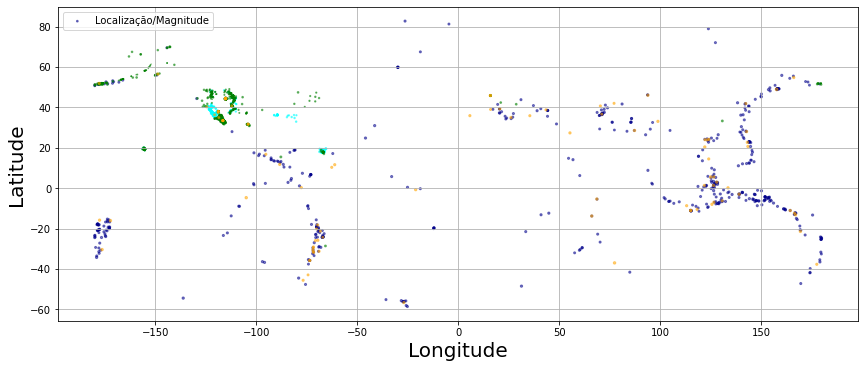

In [5]:
classColor = ['darkblue','cyan','green','orange']
vecCol = []
for i in y: vecCol.append( classColor[int(i-1)] )    

FS = (15,5) #Tamanho da figura a ser gerada
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0, 0])

ax.scatter( x[:,1], x[:,0], s=x[:,3], c=vecCol, alpha=0.5, label='Localização/Magnitude')
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)

ax.set_aspect('equal', 'box')

ax.legend(fontsize=10)
ax.grid(True)

## Separação aleatória dos dados para treinamento e avaliação

In [7]:
#Gerar conjunto de treino e avaliação a partir de uma única fonte
#N = y.shape[0]
percentAvalia = 0.33

###Procedimento anterior!
##A ordenação dos valores aleatórios segundo seu índice/argumento
#posAleatorias = np.argsort(np.random.uniform(0,1, y.shape[0] ))
#
##Subconjunto de avaliação
#yI = y[ posAleatorias[0: np.int64(np.ceil(N*percentAvalia)) ] ]
#xI = x[ posAleatorias[0: np.int64(np.ceil(N*percentAvalia)) ] , :]
#
#Subconjunto de treino
#yD = y[ posAleatorias[np.int64(np.floor(N*percentAvalia)):-1] ]
#xD = x[ posAleatorias[np.int64(np.floor(N*percentAvalia)):-1] , :]

xD, xI, yD, yI = train_test_split(x,y,test_size=percentAvalia)

## Escolha dos atributos e normalização dos dados (pelo máximo)

In [17]:
#0 - latitude, 1 - longitude, 2 - depth, 3 - mag
#4 - gap, 5 - dmin, 6 - rms, 7 - horizontalError, 8 - depthError
atributos = [2,3,4,5,6,7,8] #Permite escolhar qual atributo usar
xD_sub = xD[:,atributos]
xI_sub = xI[:,atributos]

#Normalização...
#Necessário para a convergência do SVM (normaliza os atributos)
normalizer = preprocessing.Normalizer(norm='max').fit(xD_sub)

xD_sub = normalizer.transform(xD_sub)
xI_sub = normalizer.transform(xI_sub)

## Classificação dos dados
* SVM (kernel Linear e RBF)
* Random Forest

In [18]:
#Instanciação dos classificadores
svmLin = svm.SVC(C=100, kernel='linear', decision_function_shape='ovr')
svmRBF = svm.SVC(C=100, kernel='rbf', gamma=0.5, decision_function_shape='ovr')
RF = RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_split=10, min_impurity_decrease=10**(-5))

#Treinamento dos classificadores 
svmLin.fit(xD_sub,yD)
svmRBF.fit(xD_sub,yD)
RF.fit(xD_sub,yD)

#Aplicação
yEst_svmLin = svmLin.predict(xI_sub)
yEst_svmRBF = svmRBF.predict(xI_sub)
yEst_RF = RF.predict(xI_sub)

## Avaliação do desempenho
* Matriz de confusão
* Acerto global
* Coeficiente kappa e tau

In [19]:
matConf_svmLin = confusion_matrix(yI, yEst_svmLin)
matConf_svmRBF = confusion_matrix(yI, yEst_svmRBF)
matConf_RF = confusion_matrix(yI, yEst_RF)

acGlobal_svmLin = accuracy_score(yI, yEst_svmLin, normalize=True)
kappa_svmLin = cohen_kappa_score(yI, yEst_svmLin)

acGlobal_svmRBF = accuracy_score(yI, yEst_svmRBF, normalize=True)
kappa_svmRBF = cohen_kappa_score(yI, yEst_svmRBF)

acGlobal_RF = accuracy_score(yI, yEst_RF, normalize=True)
kappa_RF = cohen_kappa_score(yI, yEst_RF)

print('---SVM com kernel Linear---')
print('Acerto Global: ',acGlobal_svmLin)
print('Kappa:         ',kappa_svmLin)
print(matConf_svmLin.T)
print('')

print('---SVM com kernel RBF---')
print('Acerto Global: ',acGlobal_svmRBF)
print('Kappa:         ',kappa_svmRBF)
print(matConf_svmRBF.T)
print('')

print('---Random Forest---')
print('Acerto Global: ',acGlobal_RF)
print('Kappa:         ',kappa_RF)
print(matConf_RF.T)
print('')

---SVM com kernel Linear---
Acerto Global:  0.6645073303784521
Kappa:          0.4111656609194524
[[ 154    1   68   27]
 [   1  772  573    2]
 [  16  293 1023    3]
 [   0    0    0    0]]

---SVM com kernel RBF---
Acerto Global:  0.686327991817252
Kappa:          0.42884973873044185
[[ 143    1   29   23]
 [   1  710  475    1]
 [  27  355 1160    8]
 [   0    0    0    0]]

---Random Forest---
Acerto Global:  0.8772587794067508
Kappa:          0.7710970208013209
[[ 155    0    6   20]
 [   0  879  125    1]
 [  10  187 1533    5]
 [   6    0    0    6]]



## Comparação entre kappa e tau

In [20]:
kappa_svmRBF, vkappa_svmRBF = compute_kappa_varkappa(matConf_svmRBF)
tau_svmRBF, vtau_svmRBF = compute_tau_varkappa(matConf_svmRBF)

kappa_RF, vkappa_RF = compute_kappa_varkappa(matConf_RF)
tau_RF, vtau_RF = compute_tau_varkappa(matConf_RF)

print('SVM+RBF ------ kappa: %f  var.kappa: %f  tau: %f  var.tau: %f'
      %(kappa_svmRBF, vkappa_svmRBF,tau_svmRBF, vtau_svmRBF))

print('Rand.Forest -- kappa: %f  var.kappa: %f  tau: %f  var.tau: %f'
      %(kappa_RF, vkappa_RF,tau_RF, vtau_RF))

SVM+RBF ------ kappa: 0.428850  var.kappa: 0.000256  tau: 0.581771  var.tau: 0.000130
Rand.Forest -- kappa: 0.771097  var.kappa: 0.000128  tau: 0.836345  var.tau: 0.000065


## Teste de hipóteses para comparação entre coefs. kappa (ou tau)

In [21]:
significancia = 0.05

kappa1 = kappa_svmRBF;  vkappa1 = vkappa_svmRBF
kappa2 = kappa_RF;  vkappa2 = vkappa_RF

z_kappa = (kappa1 - kappa2)/np.sqrt(vkappa1 + vkappa2)

#teste unilateral -- kappa1 dif. kappa2
pVal_uni = 1 - scipy.stats.norm.cdf(np.abs(z_kappa))

#teste bilateral -- kappa1 > kappa2
pVal_bil = 1 - 2*(scipy.stats.norm.cdf(np.abs(z_kappa)) - 0.5)

print('p-valor -- unilateral: %f  bilateral: %f'%(pVal_uni,pVal_bil))

if pVal_uni < significancia: print('Teste unilateral rejeita H0')
else: print('Teste unilateral não rejeita H0')
    
if pVal_bil < significancia: print('Teste bilateral rejeita H_0')
else: print('Teste unilateral não rejeita H0')

p-valor -- unilateral: 0.000000  bilateral: 0.000000
Teste unilateral rejeita H0
Teste bilateral rejeita H_0


## Prévia sobre seleção do modelo
### ("Grid Search simplificado")

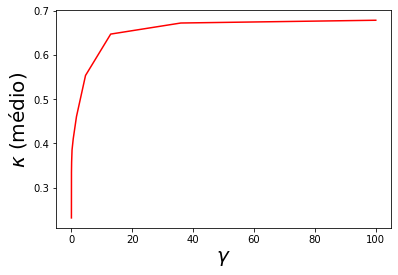

In [22]:
percentAvalia = 0.33
repeticoes = 10

fator = np.linspace(-2,2,10)
vecPerformance = []
vecGamma = []
for f in fator:
    gam = 10**f; vecGamma.append(gam)
    svmRBF = svm.SVC(C=100, kernel='rbf', gamma=gam, decision_function_shape='ovr')
    vec = []
    for j in range(repeticoes):
        xD_sel_train, xI_sel_test, yD_sel_train, yI_sel_test = train_test_split(xD_sub, yD, test_size=percentAvalia,shuffle=True)
        
        svmRBF.fit(xD_sel_train,yD_sel_train)
        yEst = svmRBF.predict(xI_sel_test)    
        vec.append( cohen_kappa_score(yI_sel_test, yEst) )
    
    vecPerformance.append(np.mean(vec))

plt.plot(vecGamma, vecPerformance, 'r-')
plt.xlabel(r'$\gamma$',fontsize=20)
plt.ylabel(r'$\kappa$ (médio)',fontsize=20)

plt.show()

In [24]:
for a,b in zip(vecGamma,vecPerformance):
    print('gamma: %f   kappa: %f'%(a,b))

gamma: 0.010000   kappa: 0.676026
gamma: 0.027826   kappa: 0.680726
gamma: 0.077426   kappa: 0.720121
gamma: 0.215443   kappa: 0.727059
gamma: 0.599484   kappa: 0.733939
gamma: 1.668101   kappa: 0.747233
gamma: 4.641589   kappa: 0.741636
gamma: 12.915497   kappa: 0.751995
gamma: 35.938137   kappa: 0.765915
gamma: 100.000000   kappa: 0.749129


## Incrementando o processo de seleção dos parâmetros
* Agora com $\gamma$ e $C$ (penalidade)

In [25]:
percentAvalia = 0.33
repeticoes = 5

N1, N2 = 5, 5

fatorG = np.linspace(-2,2,N1)
fatorP = np.linspace(-2,5,N2)

matPars = np.zeros((3,N1,N2))

for i in range(N1):
    gam = 10**fatorG[i]
    for j in range(N2):
        pen = 10**fatorP[j]
        svmRBF = svm.SVC(C=pen, kernel='rbf', gamma=gam, decision_function_shape='ovr')
        
        vec = []
        for k in range(repeticoes):
            xD_sel_train, xI_sel_test, yD_sel_train, yI_sel_test = train_test_split(xD_sub, yD, test_size=percentAvalia,shuffle=True)
        
            svmRBF.fit(xD_sel_train,yD_sel_train)
            yEst = svmRBF.predict(xI_sel_test)    
            vec.append( cohen_kappa_score(yI_sel_test, yEst) )
    
        matPars[0,i,j] = gam
        matPars[1,i,j] = pen
        matPars[2,i,j] = np.mean(vec)

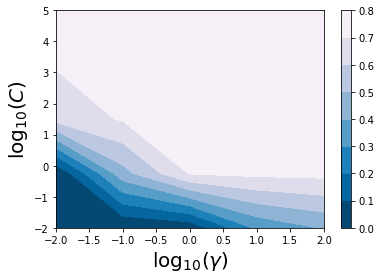

In [26]:
fig, ax = plt.subplots()
ax = plt.contourf(np.log10(matPars[0,:,:]),np.log10(matPars[1,:,:]),matPars[2,:,:],cmap=cm.PuBu_r)
plt.xlabel(r'$\log_{10}(\gamma)$',fontsize=20)
plt.ylabel(r'$\log_{10}(C)$',fontsize=20)

cbar = fig.colorbar(ax)
plt.show()